In [6]:
include("../src/PowerPhaseRetrieval.jl")
using PowerModels,CairoMakie,LinearAlgebra
import PowerPhaseRetrieval as PPR

┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.compute_basic_ac_pf! :: Tuple{Dict{String, Any}}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.calc_closest_rank_r :: Tuple{Matrix, Integer}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.calc_closest_rank_r :: Tuple{Matrix, Integer}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240


In [7]:
net = make_basic_network(parse_file("/home/sam/github/PowerSensitivities.jl/data/radial_test/case2.m"))
compute_ac_pf!(net)
S = PPR.calc_voltage_sensitivity_matrix(net)
Svp,Svq = S.vp,S.vq
K = PPR.calc_K_matrix(net)

2×2 Matrix{Float64}:
 0.285009  -0.0
 0.0       -0.285009

In [4]:
net["load"]["1"]

LoadError: UndefVarError: net not defined

In [5]:
"""
Computes the space of all active and reactive power demands that satisfy the phaseless observability condition.
"""
function phaseless_manifold(net;sample_step=0.05)
    qg_min,qg_max = net["gen"]["1"]["qmin"],net["gen"]["1"]["qmax"]
    pg_min,pg_max = net["gen"]["1"]["pmin"],net["gen"]["1"]["pmax"]
    compute_ac_pf!(net)
    S = PPR.calc_voltage_sensitivity_matrix(net)
    Svp,Svq = S.vp,S.vq
    nQ_steps = length(Vector(qg_min:sample_step:qg_max))
    nP_steps = length(Vector(pg_min:sample_step:pg_max))
    is_observable = zeros(nP_steps,nQ_steps)
    V = zeros(ComplexF64,nP_steps,nQ_steps)
    Sg = zeros(ComplexF64,nP_steps,nQ_steps)
    Pg = Vector(pg_min:sample_step:pg_max)
    Qg = Vector(qg_min:sample_step:qg_max)
    for (i,pg) in enumerate(Vector(pg_min:sample_step:pg_max))
        for (j,qg) in enumerate(Vector(qg_min:sample_step:qg_max))
            #print(qg_min,qg_max,pg_min,pg_max,pg,qg)
            net["gen"]["1"]["pg"] = pg
            net["gen"]["1"]["qg"] = qg
            compute_ac_pf!(net)
            S = PPR.calc_voltage_sensitivity_matrix(net)
            K = PPR.calc_K_matrix(net)
            Svp,Svq = S.vp,S.vq
            Sdag = Svp .+ Svq*K
            vrect = calc_basic_bus_voltage(net)
            s = calc_basic_bus_injection(net)
            is_observable[i,j] = (rank(Sdag) == 2)
            if is_observable[i,j] == 1 
                V[i,j] = vrect[1]
                Sg[i,j] = s[1]
            else 
                V[i,j] = nothing
                Sg[i,j] = nothing
            end
        end
    end
    return is_observable,V,Sg,Pg,Qg
end

phaseless_manifold

In [59]:
is_observable,V,Sg,Pg,Qg = phaseless_manifold(net)

LoadError: ArgumentError: invalid argument #4 to LAPACK call

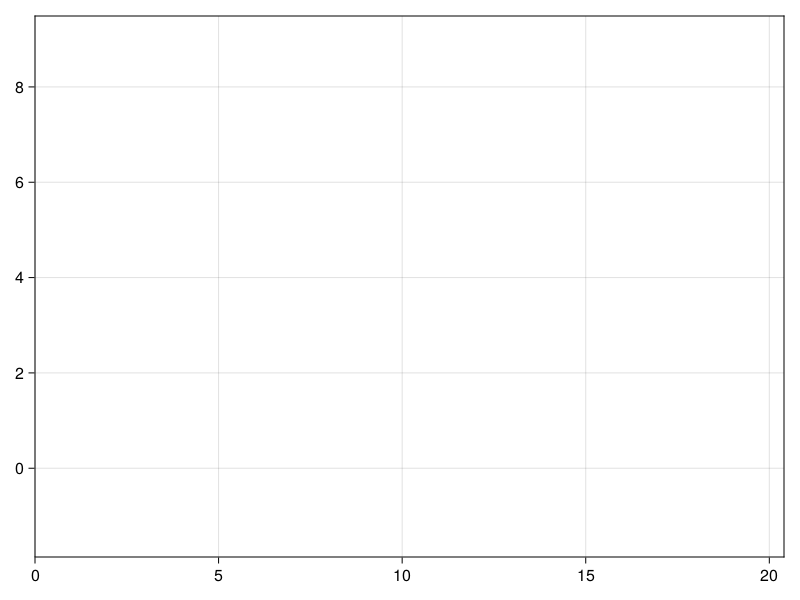

In [57]:
f = Figure()
Axis(f[1, 1])
contourf!(Pg,Qg,angle.(V))
f

In [38]:
V

205×114 Matrix{ComplexF64}:
 0.981859-0.0913893im  0.981859-0.0913893im  …  0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im     0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im     0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im     0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im     0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im  …  0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im     0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im     0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im     0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im     0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im  …  0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im     0.981859-0.0913893im
 0.981859-0.0913893im  0.981859-0.0913893im     0.981859-0.0913893im
         ⋮                                   ⋱  
 0.981859-0.0913893im  0.9

In [9]:
maximum(angle.(V))

0.0